# Starter notebook for developement

This notebook contains starter code for developing new methods for this project. This notebook demonstrates how to perform basic data loading, encoder model loading, computing representations, etc.

In [1]:
import os
import torch
import torchvision

import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, Subset

from cl_explain.encoders.simclr.resnet_wider import resnet50x1

In [2]:
imagenette_path = "/projects/leelab/data/image/imagenette2/val"
encoder_path = "/projects/leelab/cl-explainability/encoders/simclr"
device = "cpu"

In [3]:
dataset = torchvision.datasets.ImageFolder(
    imagenette_path,
    transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ]
    ),
)
data_loader = DataLoader(dataset, batch_size=32)

In [4]:
# Print the mapping between integer class label and Imagenet label.
dataset.find_classes(imagenette_path)[1]

{'n01440764': 0,
 'n02102040': 1,
 'n02979186': 2,
 'n03000684': 3,
 'n03028079': 4,
 'n03394916': 5,
 'n03417042': 6,
 'n03425413': 7,
 'n03445777': 8,
 'n03888257': 9}

In [5]:
# Select images of a particular class.
label_list = []
for _, label in data_loader:
    label_list.append(label)
labels = torch.cat(label_list)

indices = (labels == 5).nonzero().flatten()
sub_dataset = Subset(dataset, indices)
sub_data_loader = DataLoader(sub_dataset, batch_size=32)

In [6]:
# Get a batch of data.
for img, label in sub_data_loader:
    break
print(img.shape)
print(label.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32])


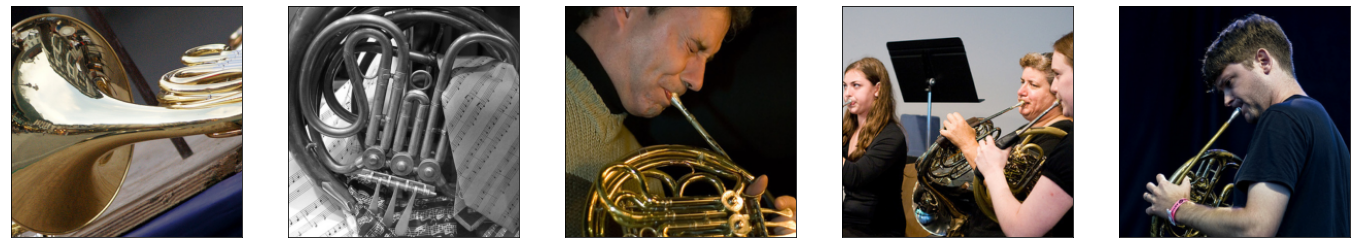

In [7]:
# Visualize some images.
fig, axes = plt.subplots(1, 5, figsize=(24, 60))
for i in range(5):
    axes[i].imshow(img[i].permute(1, 2, 0))
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [8]:
# Load a pre-trained SimCLR encoder.
encoder = resnet50x1()
state_dict_path = os.path.join(encoder_path, "resnet50-1x.pth")
state_dict = torch.load(state_dict_path, map_location="cpu")
encoder.load_state_dict(state_dict["state_dict"])
encoder.to(device)
encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn

In [10]:
# Encode the batch of images into representations.
rep = encoder(img, apply_eval_head=False)
print(rep.shape)

torch.Size([32, 2048])


In [11]:
# Compute pre-softmax outputs for classification.
out = encoder(img, apply_eval_head=True)
print(out.shape)

torch.Size([32, 1000])
